Anggota Kelompok: <br>
1. Idris Nur Huda (22.11.4594)<br>
2. Salma Nabilah Azzahra (22.11.4584)

In [3]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("data_manipulation")\
        .getOrCreate()

In [4]:
spark

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df=spark.read.csv("/content/drive/MyDrive/BDPA/SYB67_327_202411_International Migrants and Refugees.csv",header=True)

In [7]:
df.show(15)

+-------------------+-----------------------------------+----+--------------------+-----------+---------+--------------------+
|                T04|International migrants and refugees| _c2|                 _c3|        _c4|      _c5|                 _c6|
+-------------------+-----------------------------------+----+--------------------+-----------+---------+--------------------+
|Region/Country/Area|                               NULL|Year|              Series|      Value|Footnotes|              Source|
|                  1|               Total, all countr...|2005|International mig...|191,446,828|     NULL|United Nations Po...|
|                  1|               Total, all countr...|2005|International mig...|        2.9|     NULL|United Nations Po...|
|                  1|               Total, all countr...|2005|International mig...|        3.0|     NULL|United Nations Po...|
|                  1|               Total, all countr...|2005|International mig...|        2.9|     NULL|United

## Preprocessing data

In [8]:
df1=df.dropDuplicates()
df1=df1.dropna()

In [9]:
df1.show(15)

+---+-----------------------------------+----+--------------------+------+--------------------+--------------------+
|T04|International migrants and refugees| _c2|                 _c3|   _c4|                 _c5|                 _c6|
+---+-----------------------------------+----+--------------------+------+--------------------+--------------------+
| 28|                Antigua and Barbuda|2020|International mig...|  27.8| Including refugees.|United Nations Po...|
| 72|                           Botswana|2005|International mig...|84,661| Including refugees.|United Nations Po...|
|132|                         Cabo Verde|2005|Other of concern ...|     1|Data as at the en...|United Nations Hi...|
|120|                           Cameroon|2010|Other of concern ...|    66|Data as at the en...|United Nations Hi...|
|156|                              China|2005|International mig...|   0.1|For statistical p...|United Nations Po...|
|320|                          Guatemala|2005|Total refugees an.

In [10]:
df1.printSchema()

root
 |-- T04: string (nullable = true)
 |-- International migrants and refugees: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)



In [11]:
df2=df1.withColumnRenamed("T04","Region")\
       .withColumnRenamed("International migrants and refugees","Country/Area")\
       .withColumnRenamed("_c2","Year")\
       .withColumnRenamed("_c3","Series")\
       .withColumnRenamed("_c4","Value")\
       .withColumnRenamed("_c5","Footnotes")\
       .withColumnRenamed("_c6","Source")\

df2.show(15)

+------+-------------------+----+--------------------+------+--------------------+--------------------+
|Region|       Country/Area|Year|              Series| Value|           Footnotes|              Source|
+------+-------------------+----+--------------------+------+--------------------+--------------------+
|    28|Antigua and Barbuda|2020|International mig...|  27.8| Including refugees.|United Nations Po...|
|    72|           Botswana|2005|International mig...|84,661| Including refugees.|United Nations Po...|
|   132|         Cabo Verde|2005|Other of concern ...|     1|Data as at the en...|United Nations Hi...|
|   120|           Cameroon|2010|Other of concern ...|    66|Data as at the en...|United Nations Hi...|
|   156|              China|2005|International mig...|   0.1|For statistical p...|United Nations Po...|
|   320|          Guatemala|2005|Total refugees an...|   391|Data as at the en...|United Nations Hi...|
|   417|         Kyrgyzstan|2015|International mig...|   4.0| In

In [12]:
from pyspark.sql.functions import col, isnull, when, count

# Periksa nilai null di setiap kolom dan jumlahkan
df2.select([count(when(isnull(c), c)).alias(c) for c in df2.columns]).show()

+------+------------+----+------+-----+---------+------+
|Region|Country/Area|Year|Series|Value|Footnotes|Source|
+------+------------+----+------+-----+---------+------+
|     0|           0|   0|     0|    0|        0|     0|
+------+------------+----+------+-----+---------+------+



In [64]:
from pyspark.sql.types import IntegerType, StringType, DoubleType
from pyspark.sql.functions import col

# Ubah tipe data kolom 'Year' ke IntegerType
df2 = df2.withColumn("Year", col("Year").cast(IntegerType()))

# Ubah tipe data kolom 'Value' ke DoubleType
df2 = df2.withColumn("Value", col("Value").cast(DoubleType()))

#columns_to_convert = [c for c in df2.columns if c not in ['Region', 'Country/Area', 'Series', 'Footnotes', 'Source']]
#df2 = df2.withColumn("Region", col("Region").cast(DoubleType()))

# Tampilkan skema DataFrame untuk memverifikasi perubahan
df2.printSchema()

root
 |-- Region: double (nullable = true)
 |-- Country/Area: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Series: string (nullable = true)
 |-- Value: double (nullable = true)
 |-- Footnotes: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- features: vector (nullable = true)



In [57]:
df2.describe().show()

+-------+------------------+------------+------------------+--------------------+------------------+--------------------+--------------------+
|summary|            Region|Country/Area|              Year|              Series|             Value|           Footnotes|              Source|
+-------+------------------+------------+------------------+--------------------+------------------+--------------------+--------------------+
|  count|              2392|        2392|              2392|                2392|              2392|                2392|                2392|
|   mean|435.44397993311037|        NULL|2011.6517558528428|                NULL|57.442474916388015|                NULL|                NULL|
| stddev| 254.0938521364965|        NULL| 5.513563088223489|                NULL|156.11999147315447|                NULL|                NULL|
|    min|               4.0| Afghanistan|              2005|Asylum seekers, i...|               0.0|A dispute exists ...|United Nations Hi...|

In [15]:
df2 = df2.dropna(subset=["Value"])

In [16]:
# Periksa nilai null di setiap kolom dan jumlahkan
df2.select([count(when(isnull(c), c)).alias(c) for c in df2.columns]).show()

+------+------------+----+------+-----+---------+------+
|Region|Country/Area|Year|Series|Value|Footnotes|Source|
+------+------------+----+------+-----+---------+------+
|     0|           0|   0|     0|    0|        0|     0|
+------+------------+----+------+-----+---------+------+



In [63]:
import pandas as pd
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Pilih kolom numerik yang akan digunakan dalam matriks korelasi
numeric_cols = ["Year", "Value"]

# Buat VectorAssembler untuk menggabungkan kolom numerik menjadi satu vektor
feature_columns = [col for col in df2.columns if col not in ['Country/Area', 'Year', 'Series', 'Value', 'Footnotes', 'Source']]
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
#df2 = assembler.transform(df2)

# Hitung matriks korelasi menggunakan kolom "features"
correlation_matrix = Correlation.corr(df2, "features").head()

# Ekstrak matriks korelasi sebagai array NumPy
corr_array = correlation_matrix[0].toArray()

# Dapatkan nama-nama fitur dari VectorAssembler
feature_names = assembler.getInputCols()  # assembler adalah objek VectorAssembler yang Anda buat sebelumnya

# Ubah array NumPy menjadi Pandas DataFrame untuk tampilan yang lebih baik
corr_df = pd.DataFrame(corr_array, index=feature_names, columns=feature_names)

# Tampilkan matriks korelasi
print(corr_df)

df2.show(15)


          Region     Value
Region  1.000000 -0.158547
Value  -0.158547  1.000000
+------+--------------------+----+--------------------+-----+--------------------+--------------------+--------------+
|Region|        Country/Area|Year|              Series|Value|           Footnotes|              Source|      features|
+------+--------------------+----+--------------------+-----+--------------------+--------------------+--------------+
|  28.0| Antigua and Barbuda|2020|International mig...| 27.8| Including refugees.|United Nations Po...| [2020.0,27.8]|
| 132.0|          Cabo Verde|2005|Other of concern ...|  1.0|Data as at the en...|United Nations Hi...|  [2005.0,1.0]|
| 120.0|            Cameroon|2010|Other of concern ...| 66.0|Data as at the en...|United Nations Hi...| [2010.0,66.0]|
| 156.0|               China|2005|International mig...|  0.1|For statistical p...|United Nations Po...|  [2005.0,0.1]|
| 320.0|           Guatemala|2005|Total refugees an...|391.0|Data as at the en...|Unit

# EDA

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

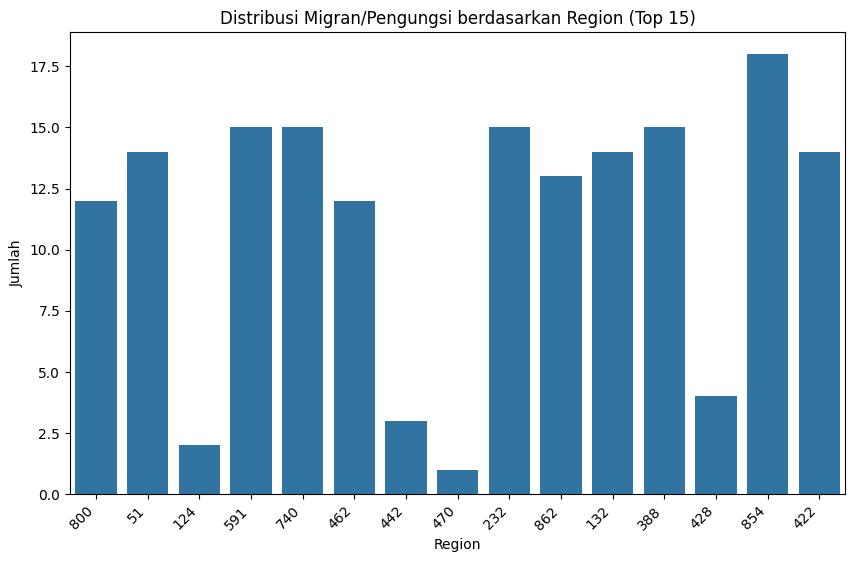

In [20]:
region_counts = df2.groupBy("Region").count().toPandas()
region_counts = region_counts.head(15)  # Ambil 15 data teratas
plt.figure(figsize=(10, 6))
sns.barplot(x="Region", y="count", data=region_counts)
plt.title("Distribusi Migran/Pengungsi berdasarkan Region (Top 15)")
plt.xlabel("Region")
plt.ylabel("Jumlah")
plt.xticks(rotation=45, ha="right")
plt.show()

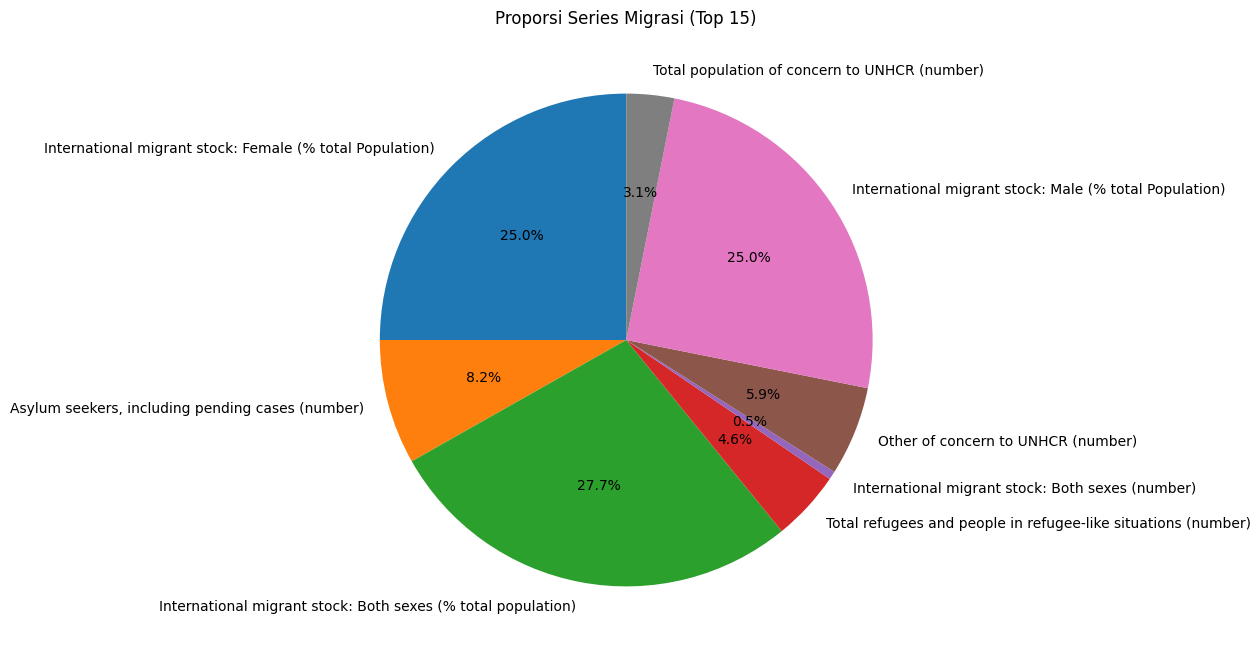

In [21]:
series_counts = df2.groupBy("Series").count().toPandas()
series_counts = series_counts.head(15)  # Ambil 15 data teratas
plt.figure(figsize=(8, 8))
plt.pie(series_counts["count"], labels=series_counts["Series"], autopct='%1.1f%%', startangle=90)
plt.title("Proporsi Series Migrasi (Top 15)")
plt.show()

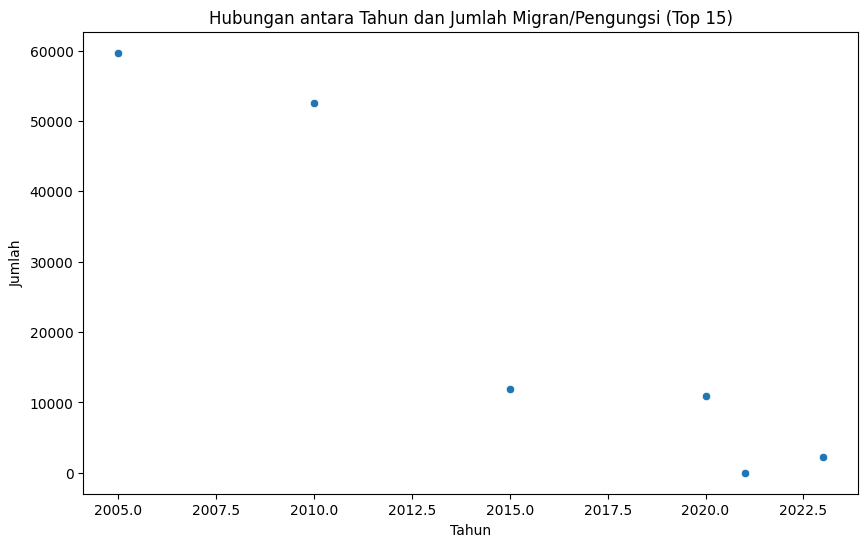

In [22]:
year_value = df2.groupBy("Year").sum("Value").toPandas()
year_value = year_value.head(15)  # Ambil 15 data teratas
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Year", y="sum(Value)", data=year_value)
plt.title("Hubungan antara Tahun dan Jumlah Migran/Pengungsi (Top 15)")
plt.xlabel("Tahun")
plt.ylabel("Jumlah")
plt.show()

# Model Machine Learning

In [79]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnull, when, count
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [43]:
df2 = df2.dropna()
data = df2.withColumn("target", col("Region").cast("integer"))

In [49]:
train_data, test_data = df2.randomSplit([0.8, 0.2], seed=42)

In [48]:
from pyspark.sql.functions import when
data = df2.withColumn("Year", when(col("Year") >= 100, 99).otherwise(col("Year")))

In [50]:
train_data.printSchema()
train_data.show(15)
print(train_data.head())
print(train_data.count())

root
 |-- Region: string (nullable = true)
 |-- Country/Area: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Series: string (nullable = true)
 |-- Value: double (nullable = true)
 |-- Footnotes: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- features: vector (nullable = true)

+------+------------+------+--------------------+-----+--------------------+--------------------+--------------+
|Region|Country/Area|  Year|              Series|Value|           Footnotes|              Source|      features|
+------+------------+------+--------------------+-----+--------------------+--------------------+--------------+
|   100|    Bulgaria|2005.0|Asylum seekers, i...|805.0|Data as at the en...|United Nations Hi...|[2005.0,805.0]|
|   104|     Myanmar|2005.0|International mig...|  0.2|Refers to foreign...|United Nations Po...|  [2005.0,0.2]|
|   104|     Myanmar|2005.0|International mig...|  0.2|Refers to foreign...|United Nations Po...|  [2005.0,0.2]|
|   

In [51]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col,isnan, when, count, isnull
data = data.dropna(subset=[c for c in data.columns if c not in ['Region', 'Country/Area', 'Year', 'Series', 'Value', 'Footnotes', 'Source', 'Features']])
for column in [c for c in data.columns if c not in ['Region', 'Country/Area', 'Year', 'Series', 'Value', 'Footnotes', 'Source', 'Features']]:
    null_count = data

In [52]:
train_data.printSchema()
test_data.printSchema()
print(f"Train data count: {train_data.count()}")
print(f"Test data count: {test_data.count()}")


root
 |-- Region: string (nullable = true)
 |-- Country/Area: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Series: string (nullable = true)
 |-- Value: double (nullable = true)
 |-- Footnotes: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- features: vector (nullable = true)

root
 |-- Region: string (nullable = true)
 |-- Country/Area: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Series: string (nullable = true)
 |-- Value: double (nullable = true)
 |-- Footnotes: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- features: vector (nullable = true)

Train data count: 1972
Test data count: 420


In [87]:
indexer = StringIndexer(inputCol="Region", outputCol="label")
indexed_df = indexer.fit(df2).transform(df2)

indexed_df.show(15)

+------+--------------------+----+--------------------+-----+--------------------+--------------------+--------------+-----+
|Region|        Country/Area|Year|              Series|Value|           Footnotes|              Source|      features|label|
+------+--------------------+----+--------------------+-----+--------------------+--------------------+--------------+-----+
|  28.0| Antigua and Barbuda|2020|International mig...| 27.8| Including refugees.|United Nations Po...| [2020.0,27.8]|123.0|
| 132.0|          Cabo Verde|2005|Other of concern ...|  1.0|Data as at the en...|United Nations Hi...|  [2005.0,1.0]| 62.0|
| 120.0|            Cameroon|2010|Other of concern ...| 66.0|Data as at the en...|United Nations Hi...| [2010.0,66.0]|100.0|
| 156.0|               China|2005|International mig...|  0.1|For statistical p...|United Nations Po...|  [2005.0,0.1]|  1.0|
| 320.0|           Guatemala|2005|Total refugees an...|391.0|Data as at the en...|United Nations Hi...|[2005.0,391.0]| 10.0|


In [97]:
from pyspark.sql.functions import when
indexed_df = indexed_df.withColumn("binary_label", when(col("Region") == "Western Asia", 1).otherwise(0))

In [98]:
# Bagi data menjadi data training dan testing
(train_data, test_data) = indexed_df.randomSplit([0.8, 0.2], seed=42)

# Buat objek RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)

# Latih model menggunakan data training
rf_model = rf.fit(train_data)

# Buat prediksi pada data testing
predictions = rf_model.transform(test_data)

# Evaluasi model menggunakan MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.02857142857142857


In [100]:
# Split the data into training and testing sets
(train_data, test_data) = indexed_df.randomSplit([0.8, 0.2], seed=42)

# Create a GBTClassifier instance and set it for multiclass using `setMulticlassPredictionStrategy`
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=100, predictionCol="prediction")

# Train the model using the training data
gbt_model = gbt.fit(train_data)

# Make predictions on the testing data
predictions = gbt_model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Py4JJavaError: An error occurred while calling o3469.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 707.0 failed 1 times, most recent failure: Lost task 0.0 in stage 707.0 (TID 422) (e20034d0ba34 executor driver): java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 125.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$SliceIterator.hasNext(Iterator.scala:268)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at scala.collection.AbstractIterator.to(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$take$2(RDD.scala:1492)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.rdd.RDD.$anonfun$take$1(RDD.scala:1492)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1465)
	at org.apache.spark.ml.tree.impl.DecisionTreeMetadata$.buildMetadata(DecisionTreeMetadata.scala:119)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.boost(GradientBoostedTrees.scala:333)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.run(GradientBoostedTrees.scala:61)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$1(GBTClassifier.scala:201)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:170)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:58)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:78)
	at jdk.internal.reflect.GeneratedMethodAccessor166.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 125.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$SliceIterator.hasNext(Iterator.scala:268)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at scala.collection.AbstractIterator.to(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$take$2(RDD.scala:1492)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [38]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming 'indexed_df' is your DataFrame with the 'label' and 'features' columns

# Split the data into training and testing sets
(train_data, test_data) = indexed_df.randomSplit([0.8, 0.2], seed=42)

# Create a LogisticRegression instance.
# Set `labelCol` to 'label', `featuresCol` to 'features',
# and enable multi-class classification using `setFamily("multinomial")`
lr = LogisticRegression(labelCol="label", featuresCol="features", family="multinomial")

# Train the model using the training data
lr_model = lr.fit(train_data)

# Make predictions on the testing data
predictions = lr_model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.011904761904761904


In [39]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming 'indexed_df' is your DataFrame with the 'label' and 'features' columns

# Split the data into training and testing sets
(train_data, test_data) = indexed_df.randomSplit([0.8, 0.2], seed=42)

# Create a DecisionTreeClassifier instance.
# Set `labelCol` to 'label' and `featuresCol` to 'features'
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Train the model using the training data
dt_model = dt.fit(train_data)

# Make predictions on the testing data
predictions = dt_model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.02857142857142857
